In [1]:
# author: Fahim Tajwar

from label_loader import *
from image_loader import *
from util import *
from models import *
from model_trainer import *
from dataset import *
import torch

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

True
Tesla K80
cpu


In [3]:
file_name_1 = '../data/labels_cells_only.xlsx'
file_name_2 = '../data/classes_800.xlsx'
file_names = [file_name_1, file_name_2]

label_reader = Label_Reader(file_names)
weight_vector = label_reader.get_weight_vector()
print(label_reader.get_all_labels())
print(label_reader.get_label_to_label_id_map())
print(weight_vector)

set(['cell dies', 'grows dense', 'grows sparse'])
{'cell dies': 0, 'grows dense': 1, 'grows sparse': 2}
tensor([0.0260, 0.0294, 0.0097])


In [4]:
prefix = "../data/well2_data/well"
suffix = "_well.png"

all_well_ids = label_reader.get_all_well_ids()
si = Single_Image_Loader(5, all_well_ids, prefix, suffix)
tensor = si.get_image_tensor()
well_id_to_image_id_map = si.get_well_to_image_id_map()
print(tensor.shape)
print(well_id_to_image_id_map)

torch.Size([351, 3, 224, 224])
{14: 243, 17: 248, 29: 265, 2082: 146, 42: 292, 2091: 147, 2094: 148, 2096: 149, 2099: 150, 52: 304, 2101: 151, 54: 308, 2107: 152, 62: 323, 2111: 153, 2114: 154, 67: 328, 68: 330, 2122: 155, 75: 341, 2124: 156, 2134: 157, 2135: 158, 2137: 159, 91: 348, 96: 349, 98: 350, 2147: 160, 100: 236, 101: 237, 111: 238, 360: 278, 2164: 161, 121: 239, 2751: 213, 128: 240, 2179: 162, 134: 241, 136: 242, 2193: 163, 2194: 164, 2199: 165, 153: 244, 159: 245, 2210: 166, 2215: 167, 169: 247, 2227: 168, 2228: 169, 183: 249, 187: 250, 2239: 171, 197: 251, 2249: 172, 202: 253, 2253: 173, 206: 254, 221: 255, 2278: 174, 2285: 175, 242: 256, 2291: 176, 250: 257, 2299: 177, 255: 258, 257: 259, 269: 260, 272: 261, 275: 262, 278: 263, 286: 264, 2337: 178, 292: 266, 2342: 179, 295: 267, 2344: 180, 2346: 181, 2351: 182, 307: 268, 2360: 183, 2361: 184, 317: 269, 2368: 185, 321: 270, 325: 271, 326: 272, 329: 273, 331: 274, 2387: 186, 2388: 187, 2389: 188, 2393: 189, 347: 275, 2397: 1

In [5]:
input_size = 3 * 224 * 224
num_classes = 3

label_to_label_id = label_reader.label_to_label_id
label_id_to_label_map = label_reader.get_label_id_to_label_map()
#print(label_id_to_label_map)

Y_label = label_reader.get_label_map()
for key in Y_label:
    Y_label[key] = label_to_label_id[Y_label[key]]

#print(Y_label)

label_id_train, label_id_val, label_id_test = get_dataset_split(Y_label)
print(len(label_id_train))
print(label_id_train)
print(len(label_id_val))
print(len(label_id_train))

280
[ 424 2870 1979 2082 1608  128 1835  384 1992 2001  451 1055 1993  587
  464 1176  326 2337 1254  579 2096 1520  683  709 2194  635  450 1831
 2344 2253   42 1891 1772  696  292  593 2107  100 2231 2239  653 1091
 1880 1931 1233 1432  111 2393 1794 1983  702 1943  542 1023 1939 1739
  418 2866 1607 2991  159   76  517 2285 1786  286 2360  767 2857 2228
  559  331  483  456 1303 1863   96 1693 2388   14 1876 1611 1265  753
 1811 1130 1998 1824 2124 2179  723  202   17 2972 1714 1849  153 1015
  355   68 1958 2114 1516 1646 1779 1893 1327 1859 2017 1016 1879 1900
  739  677  755 1036 2299  242 2899 2942 1134  101   54 1037 1977 2361
  383  434 1175 1733 1146 2939  250 1806  455  561 2406 1019  695 1614
 2414 1857  358  167 2094 1078 1913 1833 1754  317 2193 2881 2543 2432
 2862 2111  257 1685 1242 2046 2751 1460 1018  588  590 2438 1187 1812
 1194   67 2891  275 1866 2662  136 1027 1125 2484 2397 1940 1853 1324
  121 1672 1524 1689 2693  608  307 2853 1906 2368 1775 1770  623 2122
 1

In [6]:
training_set = Augmented_Dataset(tensor, label_id_train, Y_label, well_id_to_image_id_map, 
                                 final_transformation_choice)
validation_set = Augmented_Dataset(tensor, label_id_val, Y_label, well_id_to_image_id_map, transform_normalization)
test_set = Augmented_Dataset(tensor, label_id_test, Y_label, well_id_to_image_id_map, transform_normalization)

In [7]:
training_batch_size = 320
validation_batch_size = 1
test_batch_size = 1
learning_rate = 0.00005

validation_loader = torch.utils.data.DataLoader(dataset = validation_set, 
                                          batch_size = validation_batch_size, 
                                          shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test_set, 
                                          batch_size = test_batch_size, 
                                          shuffle = False)

In [8]:
deep_model = VGG16(num_classes = 3).to(device)
model = Model(deep_model, training_set, training_batch_size, learning_rate, label_id_to_label_map, 
              weight = weight_vector, imbalanced_class = True, num_epochs = 10, verbose = True, device = device)

Epoch: [1/10], Loss: 1.3117
Epoch: [2/10], Loss: 1.2497
Epoch: [3/10], Loss: 1.2584
Epoch: [4/10], Loss: 1.2339
Epoch: [5/10], Loss: 1.2191
Epoch: [6/10], Loss: 1.1753
Epoch: [7/10], Loss: 1.3279
Epoch: [8/10], Loss: 1.2043
Epoch: [9/10], Loss: 1.2888
Epoch: [10/10], Loss: 1.2693
Training done!


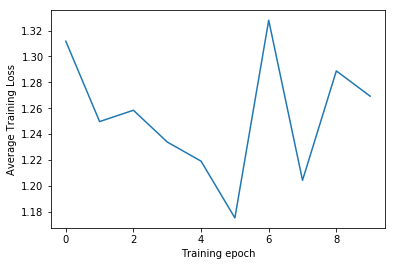

accuracy : 41.000000

('Frequency per class: ', {'cell dies': 59, 'grows dense': 56, 'grows sparse': 165})


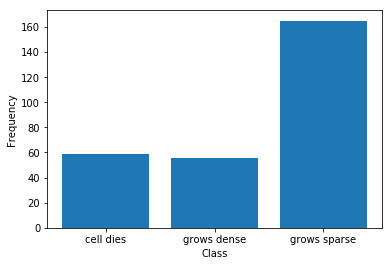

('Number of datapoints we got correct per class', {'cell dies': 16, 'grows dense': 15, 'grows sparse': 86})
('Accuracy per class', {'cell dies': 0.2711864406779661, 'grows dense': 0.26785714285714285, 'grows sparse': 0.5212121212121212})


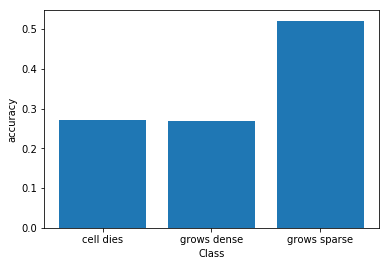

0.037860444640105656

In [9]:
model.train(device = device)

accuracy : 28.000000

('Frequency per class: ', {'cell dies': 8, 'grows dense': 9, 'grows sparse': 18})


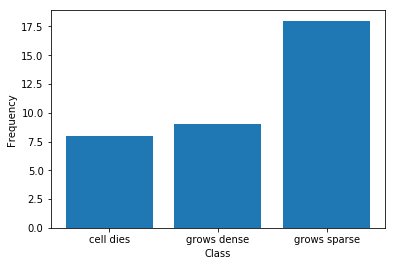

('Number of datapoints we got correct per class', {'cell dies': 2, 'grows dense': 1, 'grows sparse': 7})
('Accuracy per class', {'cell dies': 0.25, 'grows dense': 0.1111111111111111, 'grows sparse': 0.3888888888888889})


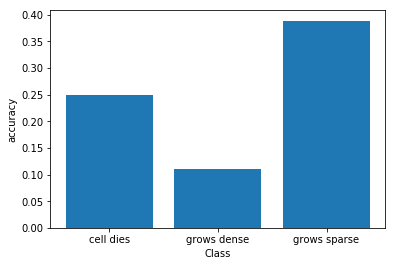

0.010802469135802469

In [10]:
model.test(validation_loader)

accuracy : 22.000000

('Frequency per class: ', {'cell dies': 7, 'grows dense': 4, 'grows sparse': 24})


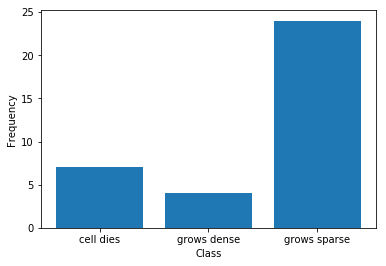

('Number of datapoints we got correct per class', {'cell dies': 0, 'grows dense': 2, 'grows sparse': 6})
('Accuracy per class', {'cell dies': 0.0, 'grows dense': 0.5, 'grows sparse': 0.25})


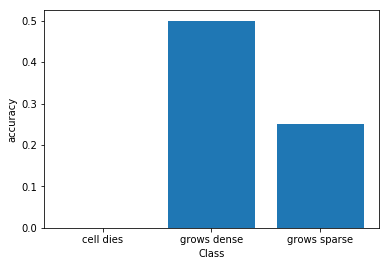

0.0

In [11]:
model.test(test_loader)